## <span style="text-decoration : underline">Import packages and datas<span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
print ('\n' + sys.version)
print("\n 3.6.2 (v3.6.2:5fd33b5926, Jul 16 2017, 20:11:06) \n [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]")


3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]

 3.6.2 (v3.6.2:5fd33b5926, Jul 16 2017, 20:11:06) 
 [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


In [2]:
import sys, os, json
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#sys.path.append('/home/claroche/PROJET_ANNEK/Analyse_textuelle')
dbs_path = module_path + "/Analyse_textuelle/query_dbs/"
list_files = os.listdir(dbs_path)

In [4]:
list_files.remove('.ipynb_checkpoints')
list_query_type = [file_name.replace('.json','') for file_name in list_files]

In [306]:
list_query_type

['AddToPlaylist_queries',
 'GetWeather_queries',
 'RateBook_queries',
 'PlayMusic_queries',
 'SearchScreeningEvent_queries',
 'SearchCreativeWork_queries',
 'BookRestaurant_queries']

In [27]:
datasets = []
for index, query_type in enumerate(list_query_type):
    if index == 3:
        pre_data = json.load(open(dbs_path + query_type + '.json', encoding = 'latin-1'))
    else:
        pre_data = json.load(open(dbs_path +query_type + '.json'))
    datasets.append(pre_data)

def flatten(dict_data):
    dict_data = dict_data["data"]
    sentence = ""
    for words in dict_data:
        sentence += words['text']
    return(sentence)

new = {list(query_type_dico.keys())[0] : list(query_type_dico.values())[0]  for query_type_dico in datasets}
new = [ {'query_type' : query_type, 'text_full' : flatten(dict_data)} for query_type, data_query_type in new.items()
       for dict_data in data_query_type  ]
data_label = pd.DataFrame(new)

In [28]:
print(data_label['text_full'].nunique())
#data_label[data_label['text_full'].duplicated() == True]
data_label.shape

13623


(13784, 2)

In [29]:
data_label.head()

,query_type,text_full
0,GetWeather,What will the weather be this year in Horsesho...
1,GetWeather,Will it be sunny one hundred thirty five days ...
2,GetWeather,Is it supposed to rain nearby my current locat...
3,GetWeather,"what is the forecast starting on september 1, ..."
4,GetWeather,how cold is it in Princeton Junction


In [30]:
data_label = data_label.drop_duplicates(subset='text_full', keep='first')
data_label.shape


(13623, 2)

In [32]:
queries = {'AddToPlaylist' : 0, 'GetWeather': 1, 'RateBook': 2, 'PlayMusic' : 3, 'SearchScreeningEvent': 4, 
           'SearchCreativeWork' : 5, 'BookRestaurant': 6}
data_label['label'] = data_label['query_type'].map(queries) 
data_label.head()


,query_type,text_full,label
0,GetWeather,What will the weather be this year in Horsesho...,1
1,GetWeather,Will it be sunny one hundred thirty five days ...,1
2,GetWeather,Is it supposed to rain nearby my current locat...,1
3,GetWeather,"what is the forecast starting on september 1, ...",1
4,GetWeather,how cold is it in Princeton Junction,1


#### Multilabel target

In [35]:
def multi_label(i):
    multi_lab = np.zeros(7)
    multi_lab[i] = 1
    return multi_lab

data_label["label_multi"] = np.nan
data_label["label_multi"] = data_label["label"].apply(multi_label)
data_label.dropna(inplace = True)

### Deep learning model

In [73]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,SpatialDropout1D,LSTM,Dense, Dropout
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import confusion_matrix

In [74]:
nb_words_max = 50000
max_seq_length = 40
embedding_dim = 100

In [75]:
tokenizer = Tokenizer(num_words=nb_words_max, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_label['text_full'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(data_label['text_full'].values)
X = pad_sequences(X, maxlen=max_seq_length)
print('Shape of data tensor:', X.shape)

Y = np.vstack(data_label['label_multi'].values)
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

Found 11637 unique tokens.
Shape of data tensor: (13623, 40)
Shape of label tensor: (13623, 7)


In [76]:
# saving tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
model = Sequential()
model.add(Embedding(nb_words_max, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(10, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.0005), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 100)           5000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 40, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 77        
Total params: 5,004,517
Trainable params: 5,004,517
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(X_train, Y_train, epochs=10, batch_size= 16, validation_data = (X_test,Y_test))

Train on 12260 samples, validate on 1363 samples
Epoch 1/10
12260/12260 [==============================] - 73s 6ms/step - loss: 1.1434 - acc: 0.7014 - val_loss: 0.4355 - val_acc: 0.9494
Epoch 2/10
12260/12260 [==============================] - 74s 6ms/step - loss: 0.4113 - acc: 0.9086 - val_loss: 0.1765 - val_acc: 0.9758
Epoch 3/10
12260/12260 [==============================] - 85s 7ms/step - loss: 0.2371 - acc: 0.9506 - val_loss: 0.1139 - val_acc: 0.9787
Epoch 4/10
12260/12260 [==============================] - 65s 5ms/step - loss: 0.1710 - acc: 0.9639 - val_loss: 0.0847 - val_acc: 0.9817
Epoch 5/10
12260/12260 [==============================] - 66s 5ms/step - loss: 0.1356 - acc: 0.9700 - val_loss: 0.0707 - val_acc: 0.9839
Epoch 6/10
12260/12260 [==============================] - 80s 7ms/step - loss: 0.1037 - acc: 0.9765 - val_loss: 0.0673 - val_acc: 0.9817
Epoch 7/10
12260/12260 [==============================] - 76s 6ms/step - loss: 0.0868 - acc: 0.9814 - val_loss: 0.0727 - val_acc:

In [79]:
model.save("models/lstm_classif_type.h5")

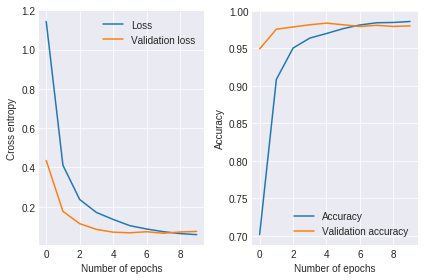

In [80]:
plt.style.use("seaborn-darkgrid")
plt.subplot(121)
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Validation loss")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy")
plt.legend()

plt.subplot(122)
plt.plot(history.history["acc"], label = "Accuracy")
plt.plot(history.history["val_acc"], label = "Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.legend()
plt.tight_layout()

plt.savefig('graphs/loss_accuracy.png')

In [81]:
import itertools
from random import *
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[191   0   0   1   0   2   0]
 [  0 202   0   0   0   0   3]
 [  0   0 204   0   0   0   0]
 [  0   0   2 189   1   3   0]
 [  0   0   0   0 184   4   0]
 [  1   0   0   1   8 175   1]
 [  0   0   0   0   0   0 191]]


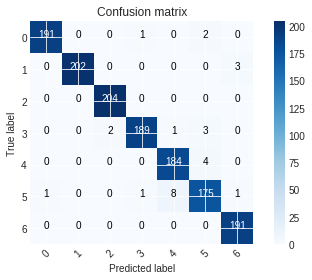

In [82]:
pred = model.predict(X_test)
n = len(X_test)

lab_pred = np.zeros(n)
lab_true = np.zeros(n)

for i in range(n):
    lab_pred[i] = np.argmax(pred[i])
    lab_true[i] = np.argmax(Y_test[i])

plot_confusion_matrix(confusion_matrix(lab_true,lab_pred), classes = np.arange(7))

In [83]:
def multi_lab_to_query_type(lab):
    return list_of_query_type[np.argmax(lab)]

multi_lab_to_query_type_vect = np.vectorize(multi_lab_to_query_type)

def predict(query_batch):
    # loading tokenizer
    with open('models/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    X = tokenizer.texts_to_sequences(query_batch)
    X = pad_sequences(X, maxlen = 40)
    
    model = load_model('models/lstm_classif_type.h5')
    pred = model.predict(X)
    print(pred)
    
    n = len(X)
    lab_pred = np.zeros(n)
    
    for i in range(n):
        lab_pred[i] = np.argmax(pred[i])
    
    return lab_pred

In [84]:
test = ["Francis petite frappe", "I want to listen to techno music", "Rate Harry Potter movie", 
        "What will the weather be like tomorow mother fucker ?", 'I want to book a table for six']
test = np.array(test)
predict(test)

[[1.06325015e-01 3.31150852e-02 1.81292593e-01 3.86205196e-01
  5.85291982e-02 2.12053925e-01 2.24790554e-02]
 [2.11131992e-03 1.35451715e-04 4.59938659e-04 9.96784925e-01
  4.77899215e-04 2.28494991e-05 7.64722517e-06]
 [4.03347518e-03 1.10067986e-03 6.86643600e-01 2.02581882e-02
  1.33469358e-01 1.50043339e-01 4.45141317e-03]
 [3.58177378e-04 9.97904062e-01 3.88314646e-07 2.77693500e-04
  4.85206168e-04 1.74316097e-04 8.00258538e-04]
 [1.29685810e-04 1.10901811e-03 3.66241366e-05 4.42417513e-06
  2.02470346e-05 1.12736714e-03 9.97572601e-01]]


array([3., 3., 2., 1., 6.])

In [60]:
list_query_type

['AddToPlaylist_queries',
 'GetWeather_queries',
 'RateBook_queries',
 'PlayMusic_queries',
 'SearchScreeningEvent_queries',
 'SearchCreativeWork_queries',
 'BookRestaurant_queries']